In [19]:
import pandas as pd
import numpy as  np

# Load the dataset
data = pd.read_csv('D:\ThuThap&XuLyData\ThuThap_XuLyData\Code\Vi\heart_disease.csv')


data.head()


,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  target    920 non-null    int64  
dtypes: float64(5), int64(3), object(7)
memory usage: 107.9+ KB


In [21]:
for col in data[['trestbps', 'chol', 'thalch']]:
    # Đếm số lượng giá trị 0 trước khi thay thế
    zero_count = data[data[col] == 0].shape[0]
    
    # Thay thế giá trị 0 bằng NaN
    data[col] = data[col].replace(0, np.nan)
    
    # In thông tin
    print(f"Column: {col}, Dem_GT_0: {zero_count}")


Column: trestbps, Dem_GT_0: 1
Column: chol, Dem_GT_0: 172
Column: thalch, Dem_GT_0: 0


In [22]:
# from sklearn.experimental import enable_iterative_imputer  # Activate experimental API
# from sklearn.impute import IterativeImputer

# Check missing values in the dataset again
missing_values_summary = data.isnull().sum()

missing_values_summary = missing_values_summary[missing_values_summary > 0]

missing_values_summary


trestbps     60
chol        202
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

In [36]:
from sklearn.experimental import enable_iterative_imputer  # Activate experimental API
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Drop the 'id' column (if it exists)
data_cleaned = data.drop(columns=['id'])

# Encode categorical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))
    label_encoders[col] = le

# Identify numeric columns for outlier detection
numeric_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
outlier_summary = {}

# Remove rows with outliers based on IQR
for col in numeric_columns:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Save outlier stats for reference
    outlier_summary[col] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outliers": ((data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)).sum()
    }

    # Remove outliers
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower_bound) & (data_cleaned[col] <= upper_bound)]

# Apply MICE imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
final_imputed_data = mice_imputer.fit_transform(data_cleaned)

# Convert back to DataFrame
final_imputed_df = pd.DataFrame(final_imputed_data, columns=data_cleaned.columns)

# Summary of missing values after re-imputation
missing_final = final_imputed_df.isnull().sum()

# Output results
print("Outlier Summary:")
print(pd.DataFrame(outlier_summary).T)
print("\nFinal Dataset Shape:", final_imputed_df.shape)
print("\nMissing Values After Processing:")
print(missing_final)


Outlier Summary:
              Q1     Q3    IQR  Lower Bound  Upper Bound  Outliers
age        47.00   60.0  13.00       27.500       79.500       0.0
trestbps  120.00  140.0  20.00       90.000      170.000      27.0
chol      209.75  275.0  65.25      111.875      372.875      21.0
thalch    124.00  160.5  36.50       69.250      215.250       0.0
oldpeak     0.00    1.5   1.50       -2.250        3.750      12.0

Final Dataset Shape: (620, 14)

Missing Values After Processing:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.000000,0.0,0.0
1,67.0,1.0,0.0,160.0,286.0,0.0,0.0,108.0,1.0,1.5,1.0,3.000000,2.0,1.0
2,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.000000,3.0,1.0
3,37.0,1.0,2.0,130.0,250.0,0.0,2.0,187.0,0.0,3.5,0.0,0.000000,2.0,0.0
4,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,3.0,0.000000,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,62.0,1.0,0.0,158.0,170.0,0.0,3.0,138.0,1.0,0.0,2.0,0.827506,1.0,1.0
616,46.0,1.0,0.0,134.0,310.0,0.0,2.0,126.0,0.0,0.0,2.0,0.655554,2.0,1.0
617,54.0,0.0,0.0,127.0,333.0,1.0,3.0,154.0,0.0,0.0,2.0,0.932705,1.0,1.0
618,55.0,1.0,0.0,122.0,223.0,1.0,3.0,100.0,0.0,0.0,2.0,1.037733,0.0,1.0


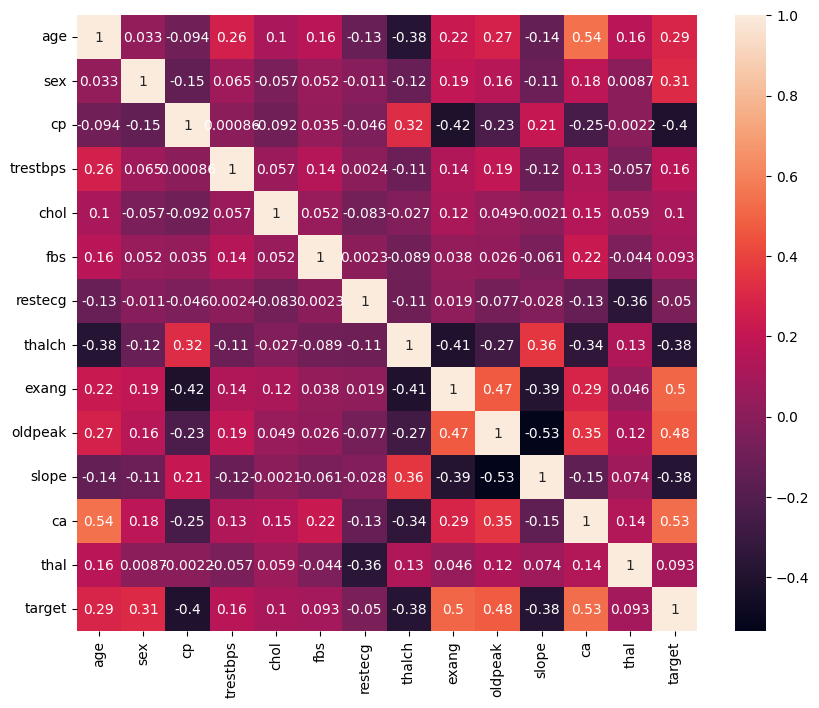

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(final_imputed_df.corr(), annot=True);